W shape: torch.Size([2952, 2952])
Epoch [1/5]  Train Loss: 0.1830,  Train Acc: 0.9441,  Test Acc: 0.9784
Epoch [2/5]  Train Loss: 0.0524,  Train Acc: 0.9836,  Test Acc: 0.9824
Epoch [3/5]  Train Loss: 0.0284,  Train Acc: 0.9914,  Test Acc: 0.9847
Epoch [4/5]  Train Loss: 0.0193,  Train Acc: 0.9939,  Test Acc: 0.9865
Epoch [5/5]  Train Loss: 0.0134,  Train Acc: 0.9957,  Test Acc: 0.9850


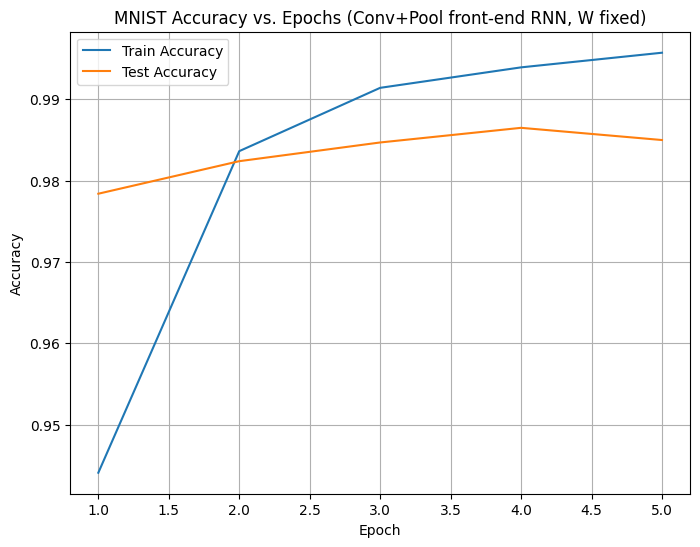

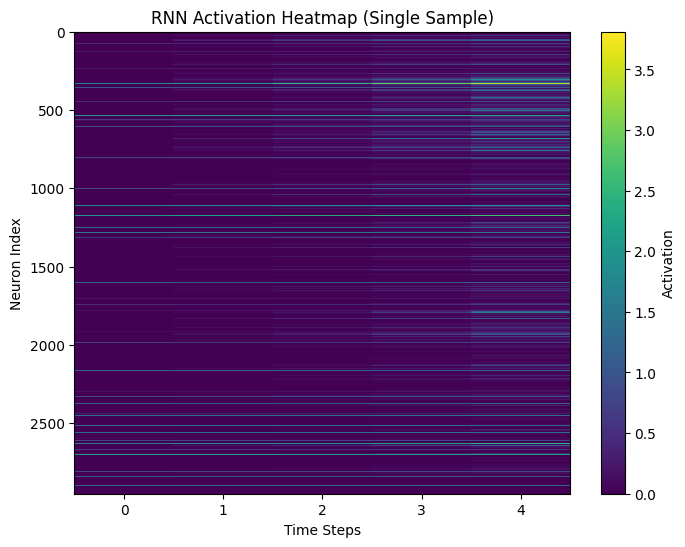

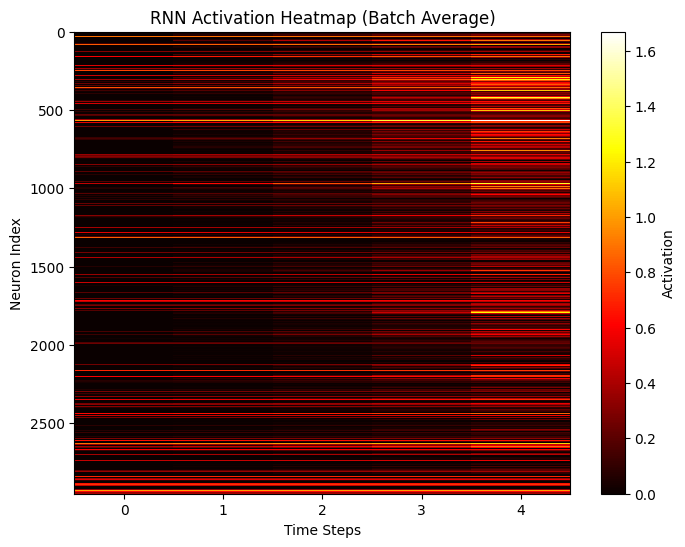

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

def load_drosophila_connectivity(csv_path):
    W_df = pd.read_csv(csv_path, index_col=0, header=0)
    W = W_df.values.astype(np.float32)

    W_min = W.min()
    W_max = W.max()
    W_norm = (W - W_min) / (W_max - W_min + 1e-8)

    return torch.from_numpy(W_norm)

#    r(t) = ReLU( r(t-1)*W + E + r(t-1) )
class DrosophilaCNNRNN(nn.Module):
    def __init__(self,
                 W_matrix,         # (hidden_dim, hidden_dim)
                 num_classes=10,
                 conv_out_channels=16,
                 time_steps=5):
        super().__init__()
        self.time_steps = time_steps
        self.hidden_dim = W_matrix.size(0)

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv_out_channels,
            kernel_size=3,
            padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2)  # 28x28 -> 14x14

        self.flat_dim = conv_out_channels * 14 * 14
        self.input_to_hidden = nn.Linear(self.flat_dim, self.hidden_dim)
        self.hidden_to_output = nn.Linear(self.hidden_dim, num_classes)

        # Register W as a buffer so it's not trained
        self.register_buffer("W_drosophila", W_matrix.clone())

    def forward(self, x):
        """
        Standard forward pass (no storage of hidden states).
        x: (batch_size, 1, 28, 28)
        """
        batch_size = x.size(0)

        c_out = self.conv1(x)  # -> (batch, conv_out_channels, 28, 28)
        c_out = F.relu(c_out)
        c_out = self.pool(c_out)  # -> (batch, conv_out_channels, 14, 14)
        c_out = c_out.view(batch_size, -1)  # flatten -> (batch, flat_dim)

        E = self.input_to_hidden(c_out)  # -> (batch, hidden_dim)

        r_prev = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        for t in range(self.time_steps):
            E_t = E if t == 0 else torch.zeros_like(E)
            r_t = r_prev @ self.W_drosophila
            r_t = r_t + E_t + r_prev
            r_t = F.relu(r_t)
            r_prev = r_t

        logits = self.hidden_to_output(r_t)  # (batch, num_classes)
        return logits

    def forward_with_activations(self, x):
        """
        Forward pass that also returns the hidden states at each time step.
        This is helpful for visualization or analysis.
        """
        batch_size = x.size(0)

        # Convolution + Pooling
        c_out = self.conv1(x)  
        c_out = F.relu(c_out)
        c_out = self.pool(c_out)         
        c_out = c_out.view(batch_size, -1)

        # Input to hidden
        E = self.input_to_hidden(c_out)

        # Keep track of hidden states across time
        hidden_states = []

        r_prev = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        for t in range(self.time_steps):
            E_t = E if t == 0 else torch.zeros_like(E)
            r_t = r_prev @ self.W_drosophila
            r_t = r_t + E_t + r_prev
            r_t = F.relu(r_t)
            hidden_states.append(r_t)  # store the entire batch's hidden states at time t
            r_prev = r_t

        logits = self.hidden_to_output(r_t)
        # hidden_states is a list of length "time_steps"
        # each element: (batch_size, hidden_dim)
        return logits, hidden_states


def load_mnist_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True,  transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_and_evaluate(model, device, num_epochs=5, lr=1e-3, pickle_path='results.pkl'):
    train_loader, test_loader = load_mnist_data(batch_size=64)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)  # [batch,1,28,28]
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / total
        train_accuracies.append(train_acc)

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_loss:.4f},  "
              f"Train Acc: {train_acc:.4f},  "
              f"Test Acc: {test_acc:.4f}")

    results = {
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    with open(pickle_path, 'wb') as f:
        pickle.dump(results, f)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('MNIST Accuracy vs. Epochs (Conv+Pool front-end RNN, W fixed)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

def plot_rnn_activation_heatmap(model, device, data_loader):
    """
    Plots two heatmaps of hidden activations across time steps:
    - x-axis: time steps (1, 2, ..., model.time_steps)
    - y-axis: neuron index (0, 1, ..., hidden_dim - 1)
    
    The function creates:
    1) A heatmap for the first sample in the batch (individual sample).
    2) A heatmap showing the average activation across the batch (batch average).
    """
    model.eval()

    # 1) Grab a single batch of data
    images, _ = next(iter(data_loader))
    images = images.to(device)

    # 2) Use the specialized forward method that returns activations
    with torch.no_grad():
        _, hidden_states = model.forward_with_activations(images)

    # 3) hidden_states is a list of length = model.time_steps
    #    Each element has shape (batch_size, hidden_dim).
    
    # (a) Get the activations for the first sample in the batch (single example)
    first_sample_activations = [hs[0].cpu().numpy() for hs in hidden_states]
    activations_single = np.array(first_sample_activations)  # shape: (time_steps, hidden_dim)

    # (b) Compute the average activation across the batch
    batch_activations = [hs.mean(dim=0).cpu().numpy() for hs in hidden_states]
    activations_batch_avg = np.array(batch_activations)  # shape: (time_steps, hidden_dim)

    # 4) Plot the heatmap for the **single sample**
    plt.figure(figsize=(8, 6))
    plt.imshow(activations_single.T, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Activation')
    plt.xlabel('Time Steps')
    plt.ylabel('Neuron Index')
    plt.title('RNN Activation Heatmap (Single Sample)')
    plt.show()

    # 5) Plot the heatmap for the **batch average**
    plt.figure(figsize=(8, 6))
    plt.imshow(activations_batch_avg.T, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar(label='Activation')
    plt.xlabel('Time Steps')
    plt.ylabel('Neuron Index')
    plt.title('RNN Activation Heatmap (Batch Average)')
    plt.show()


if __name__ == '__main__':
    csv_path = './data/ad_connectivity_matrix.csv'
    W_torch = load_drosophila_connectivity(csv_path)
    print("W shape:", W_torch.shape) 

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DrosophilaCNNRNN(
        W_matrix=W_torch,
        num_classes=10,
        conv_out_channels=16, 
        time_steps=5
    ).to(device)

    # Train the model (optional)
    results = train_and_evaluate(
        model=model,
        device=device,
        num_epochs=5,
        lr=1e-3,
        pickle_path='drosophila_cnnrnn_results.pkl'
    )

    # Plot heatmaps on the TEST set
    _, test_loader = load_mnist_data(batch_size=64)
    plot_rnn_activation_heatmap(model, device, test_loader)
